In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
#DATASETS = ['A','B','C','D','E','F']
DATASETS = ['A','B','D','E']
datalist = []

for dataset in DATASETS:
    files = [i[:-4] for i in os.listdir(f'../data/{dataset}/formatted/') if i.find('.npy')!=-1]
    for file in files:
        datalist.append(f'../data/{dataset}/formatted/'+file)



# Check the length fits json and numpy

In [15]:
for data in tqdm(datalist):
    signal = np.load(data+'.npy')
    meta = json.load(open(data+'.json'))
    
    if meta['shape'][0] != signal.shape[0]:
        break
    

100%|██████████| 32683/32683 [03:15<00:00, 167.02it/s]


# Check the length distribution, all datasets

In [ ]:
length_list = []
exclusions = []
exclusions_labels = []
exclusions_digits = []

for data in tqdm(datalist):
    meta = json.load(open(data+'.json'))
    if meta['labels_training_merged'] is None:
        continue
    if meta['shape'][0] > 38000:
        file_name = data.split('/')     
        exclusions.append(file_name[-1])
        exclusions_labels.append(meta['labels_full'])
        exclusions_digits.append(meta['labels_training_merged'])
    length_list.append(meta['shape'][0])

    
sns.distplot(length_list)

  7%|▋         | 2202/32683 [00:12<02:53, 175.23it/s]

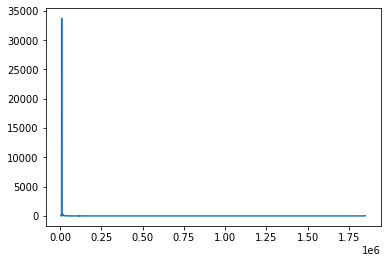

In [21]:
hist = np.histogram(length_list,2000)
plt.plot(hist[1][:-1][:100],hist[0])

In [31]:
np.percentile(length_list,99)

38000.0

# Check distribution of classes, calculate weights

In [5]:
labels = []

for data in tqdm(datalist):
    meta = json.load(open(data+'.json'))
    if meta['shape'][0] > 38000:
        continue
    elif meta['labels_training_merged'] is None:
        continue
    else:
        labels.append(meta['labels_training_merged'])
    

    
labels = np.array(labels)

100%|██████████| 6877/6877 [00:38<00:00, 179.30it/s]


In [13]:
weights = np.sum(labels,axis=0)
weights = weights / np.sum(weights)
weights.tolist()

[0.13184772516248838,
 0.21875580315691737,
 0.0,
 0.0,
 0.33593314763231197,
 0.0,
 0.0,
 0.0,
 0.04271123491179202,
 0.0,
 0.0,
 0.0,
 0.10306406685236769,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.16768802228412255,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]